In [193]:
import logging; logging.basicConfig(level=logging.DEBUG)
import time

from dropbot import SerialProxy
from ipywidgets import widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from base_node import BaseNode

%matplotlib inline

try:
    del proxy
except:
    pass

# Connect to the connected DropBot and print it's properties
proxy = SerialProxy()

print proxy.properties
print "\nuuid:\t\t\t%s\n" % proxy.uuid

#proxy.reset_config()
proxy.update_config(max_voltage=150, i2c_address=10)

print "i2c_scan:"

for address in proxy.i2c_scan():
    if address in [32, 33, 34]:
        node = BaseNode(proxy, address)
        print "\t%s: %s v%s, firmware v%s, uuid: %s" % (address, node.name(),
            node.hardware_version(), node.software_version(), node.uuid)
    else:
        print "\t%s: ?" % address

print "\nsoft_i2c_scan:", proxy.soft_i2c_scan()

proxy.initialize_switching_boards()

print "number of channels:", proxy.number_of_channels

print "\nconfig:"
print proxy.config

INFO:base_node_rpc.proxy:Successfully connected to dropbot on port COM3


base_node_software_version                                                     
package_name                                                            dropbot
display_name                                                            DropBot
manufacturer                                                        Wheeler Lab
url                           http://github.com/wheeler-microfluidics/dropbo...
software_version                                                            1.9
dtype: object

uuid:			0000816f-0700-db9e-1640-0f00454e0237

i2c_scan:
	10: ?
	32: HV Switching Board  v3.1 , firmware v0.5 , uuid: 35c24555-9b78-4c08-b62e-a4e4c6b285bb
	33: HV Switching Board  v3.1 , firmware v0.5 , uuid: 28b829ec-2409-427a-ab51-13d1edc44b34
	34: HV Switching Board  v3.1 , firmware v0.5 , uuid: a232342b-ec1f-4c6c-a99e-7419413a9fd8

soft_i2c_scan: [44]
number of channels: 120

config:
max_voltage                        150
R7                              8759.7
min_frequency                      10

rms_error = 4.7%

Checking for shorts. Channel 119: OK                                              
No shorts


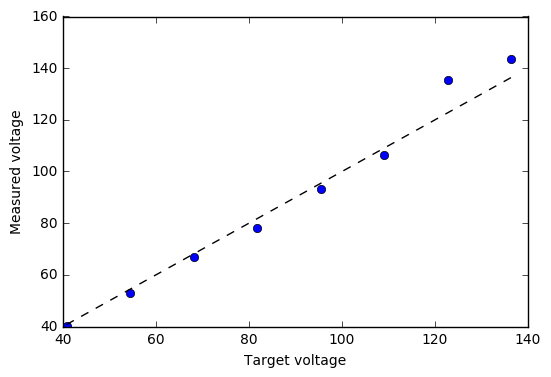

In [194]:
# test the measured voltage for a range of target voltages
proxy.voltage = proxy.min_waveform_voltage
proxy.hv_output_enabled = True
measured_voltage = []

voltage = np.linspace(proxy.min_waveform_voltage,
                      proxy.max_waveform_voltage,
                      10)[1:-1]
for v in voltage:
    proxy.voltage = v
    time.sleep(.5)
    measured_voltage.append(proxy.measured_voltage)

measured_voltage = np.array(measured_voltage)
proxy.voltage = proxy.min_waveform_voltage + 5

plt.figure()
# plot the measured vs target votage
plt.plot(voltage, measured_voltage, 'o')
plt.plot(voltage, voltage, 'k--')
plt.xlabel('Target voltage')
plt.ylabel('Measured voltage')

# calculate the average rms error
r = measured_voltage - voltage
print 'rms_error = %.1f%%\n' % (100 * np.sqrt(np.mean((r / voltage)**2)))

proxy.hv_output_enabled = False
proxy.hv_output_selected = False

shorts = []
for i in range(0, proxy.number_of_channels):
    state = np.zeros(proxy.number_of_channels)
    state[i] = 1
    proxy.state_of_channels = state
    time.sleep(0.05)
    short = proxy.analog_read(0) / 1024.0 * 3.3 < 1
    print "\rChecking for shorts. Channel %d: %s        " % (i, "SHORT"
                                          if short
                                          else "OK"),
    if short:
        shorts.append(i)
    
proxy.state_of_channels = np.zeros(proxy.number_of_channels)

if len(shorts):
    print "\nShorts on channels %s" % ", ".join([str(x) for x in shorts])
else:
    print "\nNo shorts"
    
proxy.hv_output_selected = True

In [196]:
import teensy_minimal_rpc as tmr
import teensy_minimal_rpc.adc_sampler

n_samples = 200
gain_power = 5

#sampling_rate, adc_settings, adc_sampler = \
#    proxy.analog_reads_config('PGA0', n_samples, gain_power=gain_power)

sampling_rate, adc_settings, adc_sampler = \
    proxy.analog_reads_config('A11', n_samples)

ch -1: 2.79 pF
ch 0: 12.04 pF
ch 1: 99.39 pF
ch 2: 509.71 pF


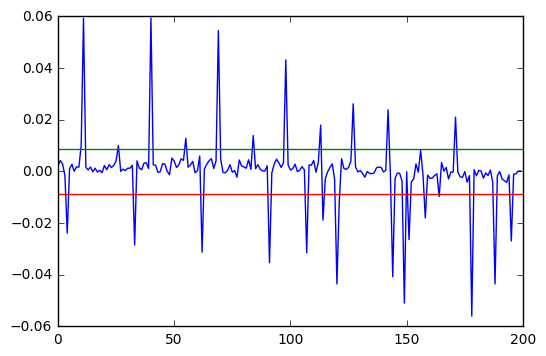

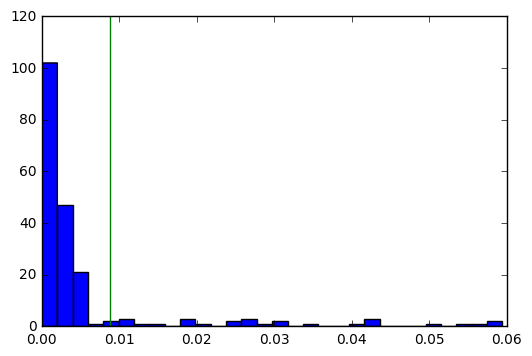

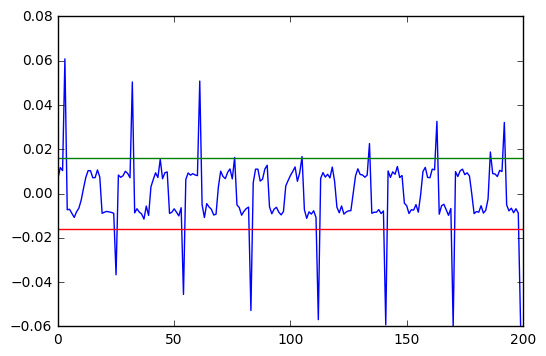

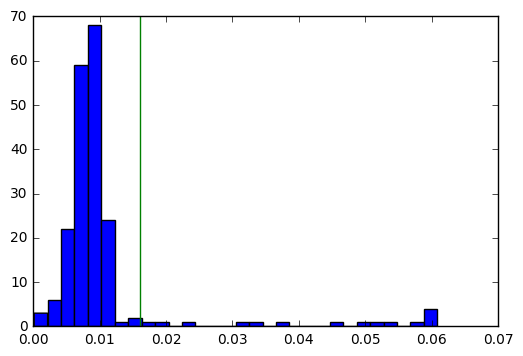

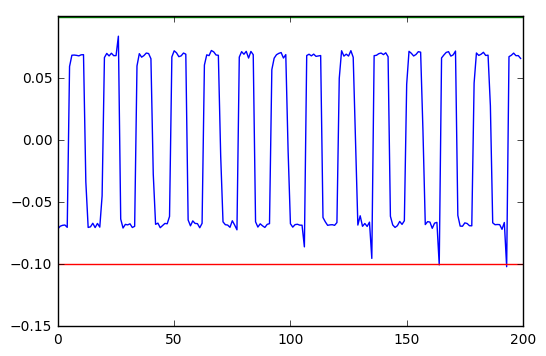

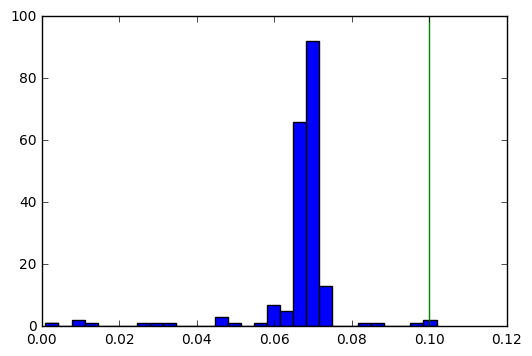

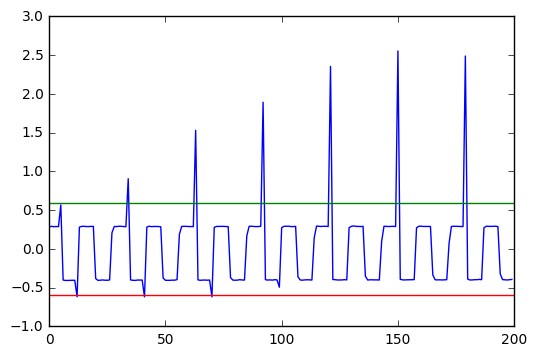

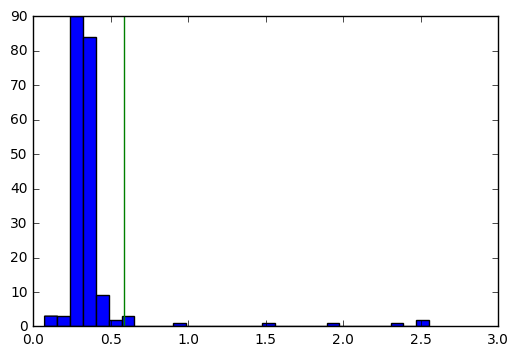

In [197]:
# test channels using the test-board

def sample_feedback(i, plot=False, n_samples=50, gain_power=5):
    c = proxy.select_on_board_test_capacitor(i)
    time.sleep(.05)
    df_adc_results = (adc_sampler.start_read(sample_rate_hz=sampling_rate)
                      .get_results())
    df_volts, df_adc_results = \
        tmr.adc_sampler.format_adc_results(df_adc_results, adc_settings)
    c = proxy.select_on_board_test_capacitor(-1)
    v_gnd = np.mean(df_volts)
    v_rms = np.sqrt(np.mean((df_volts - v_gnd)**2))
    v_abs = np.abs(df_volts - v_gnd)
    v_abs_mean = np.mean(v_abs)
    filter_th = v_abs_mean * 1.5
    v_filtered_mean = np.mean(v_abs[v_abs < filter_th])
    c_meas = v_filtered_mean.values[0] / proxy.voltage * 0.15e-6
    
    if plot:
        plt.figure()
        plt.plot(df_volts.values - v_gnd[0])
        plt.plot(plt.xlim(), [filter_th, filter_th], 'k--')
        plt.plot(plt.xlim(), [-filter_th, -filter_th], 'k--')
        plt.figure()
        plt.hist(np.abs(df_volts.values - v_gnd[0]), 30)
        plt.plot([filter_th, filter_th], plt.ylim(), 'k--')
    return c_meas

proxy.voltage = 100
proxy.hv_output_enabled = True

c = []
for i in [-1, 0, 1, 2]:
    c = sample_feedback(i, True)
    print "ch %d: %.2f pF" % (i, c / 1e-12)

proxy.hv_output_enabled = False

channel (120/120) 119: 12.54 pF                                                                 

Test took 14.4 s
0 of 120 switches bad (0.0 %)


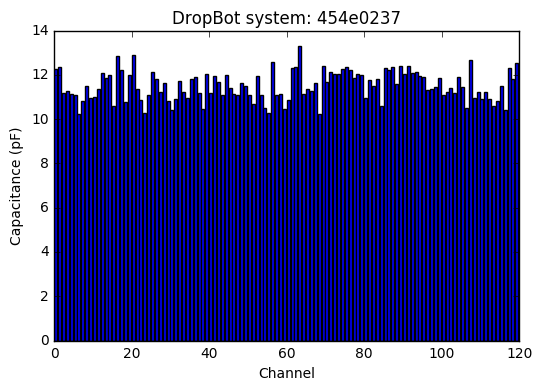

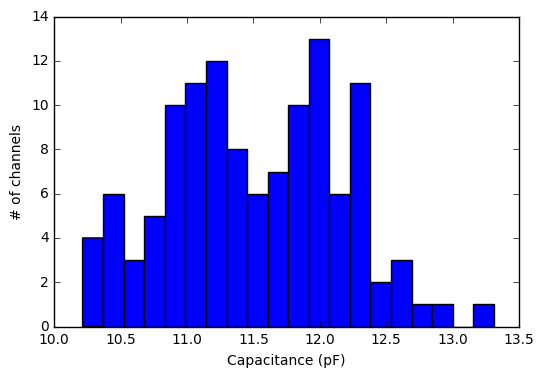

Exception in thread Thread-51:
Traceback (most recent call last):
  File "C:\Users\Ryan\MicroDrop\lib\threading.py", line 801, in __bootstrap_inner
    self.run()
  File "C:\Users\Ryan\MicroDrop\lib\site-packages\base_node_rpc\queue.py", line 184, in run
    self.parse_available()
  File "C:\Users\Ryan\MicroDrop\lib\site-packages\base_node_rpc\queue.py", line 191, in parse_available
    self.message_parser.parse_available(self.stream)
  File "C:\Users\Ryan\MicroDrop\lib\site-packages\base_node_rpc\queue.py", line 55, in parse_available
    data = stream.read()
  File "C:\Users\Ryan\MicroDrop\lib\site-packages\base_node_rpc\queue.py", line 114, in read
    return self.serial_device.read(self.serial_device.inWaiting())
  File "C:\Users\Ryan\MicroDrop\lib\site-packages\serial\serialutil.py", line 572, in inWaiting
    return self.in_waiting
  File "C:\Users\Ryan\MicroDrop\lib\site-packages\serial\serialwin32.py", line 257, in in_waiting
    raise SerialException('call to ClearCommError fa

In [200]:
proxy.voltage = 100
proxy.hv_output_enabled = True

start_time = time.time()
threshold = 5e-12
c = []
number_of_channels = proxy.number_of_channels
test_channels = np.arange(0, 120)

for i, channel_i in enumerate(test_channels):
    state = np.zeros(number_of_channels)
    state[channel_i] = 1
    proxy.state_of_channels = state
    c.append(sample_feedback(-1, n_samples=50))
    print "\rchannel (%3d/%3d) %d: %s%s        " % (i + 1, len(test_channels),
                                                    channel_i, "%.2f pF" % (c[-1] / 1e-12),
                                                    " (BAD)"
                                                    if c[-1] < threshold
                                                    else ""),
proxy.state_of_channels = np.zeros(proxy.number_of_channels)
proxy.hv_output_enabled = False

print ''

c = np.array(c)
bad_count = np.count_nonzero(c < 5e-12)

plt.figure()
plt.bar(range(len(c)), c / 1e-12)
plt.title('DropBot system: %s' % str(proxy.uuid)[-8:])
plt.xlabel("Channel");
plt.ylabel("Capacitance (pF)")

plt.figure()
plt.hist(c / 1e-12, 20)
plt.ylabel("# of channels")
plt.xlabel("Capacitance (pF)")

print "\nTest took %.1f s" % (time.time() - start_time)
print "%d of %d switches bad (%.1f %%)"  % (bad_count, len(c), float(bad_count) / len(c)*100)

if bad_count:
    print "The following channels failed:", ", ".join([str(x) for x in test_channels[c < 5e-12]])

In [ ]:
channel_selection = widgets.SelectMultiple(options=range(proxy.number_of_channels),
                                           style={'height': '500px'},
                                           description='Channels:',
                                           disabled=False)
def set_actuated_channels(message):
    c = proxy.select_on_board_test_capacitor(-1)
    states = np.zeros(proxy.number_of_channels)
    states[message.get('new', [])] = 1
    proxy.state_of_channels = states
    
# Start with all channels off.
proxy.hv_output_enabled = True
proxy.state_of_channels = np.zeros(proxy.number_of_channels)
channel_selection.observe(set_actuated_channels, names='value', type='change')

channel_selection